In [ ]:
import os
import pathlib
import shutil
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
# Setting random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# ===============================================
# PART 1: DATA PREPARATION
# ===============================================


In [ ]:
def prepare_data():
    """Download and prepare the IMDB dataset"""
    print("=" * 80)
    print("PART 1: DATA PREPARATION")
    print("=" * 80)

    # Download data
    if not os.path.exists("aclImdb"):
        print("Downloading IMDB dataset...")
        os.system("curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz")
        os.system("tar -xf aclImdb_v1.tar.gz")
        os.system("rm -r aclImdb/train/unsup")

    # Assignment requirements
    batch_size = 32
    base_dir = pathlib.Path("aclImdb")
    val_dir = base_dir / "val"
    train_dir = base_dir / "train"

    # Create validation directory
    if not os.path.exists(val_dir):
        for category in ("neg", "pos"):
            os.makedirs(val_dir / category, exist_ok=True)
            files = os.listdir(train_dir / category)
            random.Random(1337).shuffle(files)
            num_val_samples = int(0.2 * len(files))
            val_files = files[-num_val_samples:]
            for fname in val_files:
                shutil.move(train_dir / category / fname,
                          val_dir / category / fname)

    # Load datasets
    train_ds = keras.utils.text_dataset_from_directory(
        "aclImdb/train", batch_size=batch_size
    )
    val_ds = keras.utils.text_dataset_from_directory(
        "aclImdb/val", batch_size=batch_size
    )
    test_ds = keras.utils.text_dataset_from_directory(
        "aclImdb/test", batch_size=batch_size
    )

    return train_ds, val_ds, test_ds

def prepare_limited_dataset(train_ds, val_ds, test_ds,
                           max_length=150, max_tokens=10000,
                           num_train_samples=100, num_val_samples=10000):
    """
    Prepare datasets with assignment constraints:
    - Cutoff reviews after 150 words
    - Restrict training samples to 100
    - Validate on 10,000 samples
    - Consider only top 10,000 words
    """
    print(f"\nPreparing limited dataset:")
    print(f"  Max sequence length: {max_length}")
    print(f"  Max tokens: {max_tokens}")
    print(f"  Training samples: {num_train_samples}")
    print(f"  Validation samples: {num_val_samples}")

    # Extract text for vectorization adaptation
    text_only_train_ds = train_ds.map(lambda x, y: x)

    # Text vectorization layer
    text_vectorization = layers.TextVectorization(
        max_tokens=max_tokens,
        output_mode="int",
        output_sequence_length=max_length,
    )
    text_vectorization.adapt(text_only_train_ds)

    # Vectorize datasets
    int_train_ds = train_ds.map(
        lambda x, y: (text_vectorization(x), y),
        num_parallel_calls=4)
    int_val_ds = val_ds.map(
        lambda x, y: (text_vectorization(x), y),
        num_parallel_calls=4)
    int_test_ds = test_ds.map(
        lambda x, y: (text_vectorization(x), y),
        num_parallel_calls=4)

    # Limit training samples
    int_train_ds_limited = int_train_ds.take(num_train_samples // 32 + 1)

    # Limit validation samples
    int_val_ds_limited = int_val_ds.take(num_val_samples // 32 + 1)

    return (int_train_ds_limited, int_val_ds_limited, int_test_ds,
            text_vectorization, max_tokens, max_length)

# ===============================================
# PART 2: MODEL WITH LEARNED EMBEDDING LAYER
# ===============================================

In [ ]:
def build_model_with_embedding(max_tokens, max_length, embedding_dim=256):
    """Build model with learned embedding layer"""
    print(f"\nBuilding model with learned embedding (dim={embedding_dim})...")

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = layers.Embedding(
        input_dim=max_tokens,
        output_dim=embedding_dim,
        mask_zero=True
    )(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer="rmsprop",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

# ===================================================
# PART 3: MODEL WITH PRETRAINED GLOVE EMBEDDINGS
# ===================================================

In [ ]:
def load_glove_embeddings(embedding_dim=100):
    """Load GloVe pretrained embeddings"""
    glove_file = f"glove.6B.{embedding_dim}d.txt"

    if not os.path.exists(glove_file):
        print("Downloading GloVe embeddings...")
        os.system("wget http://nlp.stanford.edu/data/glove.6B.zip")
        os.system("unzip -q glove.6B.zip")

    print(f"Loading GloVe embeddings from {glove_file}...")
    embeddings_index = {}
    with open(glove_file, encoding='utf-8') as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print(f"Found {len(embeddings_index)} word vectors.")
    return embeddings_index

def prepare_glove_embedding_matrix(text_vectorization, embeddings_index,
                                   max_tokens, embedding_dim=100):
    """Prepare GloVe embedding matrix"""
    print("Preparing GloVe embedding matrix...")

    vocabulary = text_vectorization.get_vocabulary()
    word_index = dict(zip(vocabulary, range(len(vocabulary))))

    embedding_matrix = np.zeros((max_tokens, embedding_dim))
    words_found = 0

    for word, i in word_index.items():
        if i < max_tokens:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                words_found += 1

    print(f"Found embeddings for {words_found}/{min(len(vocabulary), max_tokens)} words")
    return embedding_matrix

def build_model_with_pretrained_embedding(embedding_matrix, max_tokens, embedding_dim=100):
    """Build model with pretrained GloVe embeddings"""
    print(f"\nBuilding model with pretrained GloVe embeddings (dim={embedding_dim})...")

    embedding_layer = layers.Embedding(
        max_tokens,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
        mask_zero=True,
    )

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer="rmsprop",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

# ===============================================
# PART 4: TRAINING AND EVALUATION
# ===============================================

In [ ]:
def train_and_evaluate(model, train_ds, val_ds, test_ds, model_name, epochs=10):
    """Train and evaluate a model"""
    print(f"\n{'=' * 80}")
    print(f"Training {model_name}")
    print(f"{'=' * 80}")

    callbacks = [
        keras.callbacks.ModelCheckpoint(
            f"{model_name}.keras",
            save_best_only=True,
            monitor='val_accuracy'
        ),
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True
        )
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    print(f"\n{model_name} - Test accuracy: {test_acc:.4f}")

    return history, test_acc

# =================================================
# PART 5: COMPARISON WITH VARYING TRAINING SAMPLES
# =================================================

In [ ]:
def compare_training_sample_sizes(train_ds, val_ds, test_ds, text_vectorization,
                                 embeddings_index, max_tokens, max_length):
    """
    Question 2: Compare performance with different training sample sizes
    to find the crossover point where learned embeddings outperform pretrained
    """
    print("\nTesting with multiple training sample sizes to find crossover point...")
    print("This will take some time as we train models with different data sizes.")

    # Test with different training sample sizes
    sample_sizes = [50, 100, 200, 500, 1000, 2000, 5000, 10000]

    results = {
        'sample_sizes': [],
        'embedding_acc': [],
        'pretrained_acc': []
    }

    embedding_dim = 100
    embedding_matrix = prepare_glove_embedding_matrix(
        text_vectorization, embeddings_index, max_tokens, embedding_dim
    )

    for num_samples in sample_sizes:
        print(f"\n--- Testing with {num_samples} training samples ---")

        # Create limited datasets
        limited_train_ds = train_ds.map(
            lambda x, y: (text_vectorization(x), y),
            num_parallel_calls=4
        ).take(num_samples // 32 + 1)

        limited_val_ds = val_ds.map(
            lambda x, y: (text_vectorization(x), y),
            num_parallel_calls=4
        ).take(10000 // 32 + 1)

        test_ds_int = test_ds.map(
            lambda x, y: (text_vectorization(x), y),
            num_parallel_calls=4
        )

        # Train model with learned embedding
        print(f"\n1. Learned Embedding ({num_samples} samples):")
        model_emb = build_model_with_embedding(max_tokens, max_length, embedding_dim)
        _, acc_emb = train_and_evaluate(
            model_emb, limited_train_ds, limited_val_ds, test_ds_int,
            f"learned_emb_{num_samples}", epochs=10
        )

        # Train model with pretrained embedding
        print(f"\n2. Pretrained GloVe Embedding ({num_samples} samples):")
        model_glove = build_model_with_pretrained_embedding(
            embedding_matrix, max_tokens, embedding_dim
        )
        _, acc_glove = train_and_evaluate(
            model_glove, limited_train_ds, limited_val_ds, test_ds_int,
            f"pretrained_emb_{num_samples}", epochs=10
        )

        results['sample_sizes'].append(num_samples)
        results['embedding_acc'].append(acc_emb)
        results['pretrained_acc'].append(acc_glove)

        print(f"\nResults for {num_samples} samples:")
        print(f"  Learned Embedding: {acc_emb:.4f}")
        print(f"  Pretrained GloVe: {acc_glove:.4f}")
        print(f"  Winner: {'Learned' if acc_emb > acc_glove else 'Pretrained'}")

    return results

def plot_results(results):
    """Plot comparison results"""
    plt.figure(figsize=(12, 6))

    plt.plot(results['sample_sizes'], results['embedding_acc'],
             marker='o', label='Learned Embedding', linewidth=2)
    plt.plot(results['sample_sizes'], results['pretrained_acc'],
             marker='s', label='Pretrained GloVe', linewidth=2)

    plt.xlabel('Number of Training Samples', fontsize=12)
    plt.ylabel('Test Accuracy', fontsize=12)
    plt.title('Learned vs Pretrained Embeddings: Performance vs Training Data Size',
              fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.xscale('log')

    # Add crossover point annotation
    for i in range(len(results['sample_sizes']) - 1):
        if (results['embedding_acc'][i] <= results['pretrained_acc'][i] and
            results['embedding_acc'][i+1] > results['pretrained_acc'][i+1]):
            plt.axvline(x=results['sample_sizes'][i], color='red',
                       linestyle='--', alpha=0.5, label='Crossover point')
            break

    plt.tight_layout()
    plt.savefig('embedding_comparison.png', dpi=300, bbox_inches='tight')
    print("\nPlot saved as 'embedding_comparison.png'")
    plt.show()


# =========================================
# MAIN EXECUTION
# =========================================


PART 1: DATA PREPARATION
Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.

QUESTION 1: Which approach works better?
  a) Embedding layer (learned from scratch)
  b) Pretrained word embedding (GloVe)

Preparing limited dataset:
  Max sequence length: 150
  Max tokens: 10000
  Training samples: 100
  Validation samples: 10000

Testing approach (a): Learned Embedding Layer

Building model with learned embedding (dim=100)...

Training learned_embedding_100samples
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 499ms/step - accuracy: 0.4448 - loss: 0.6941 - val_accuracy: 0.5248 - val_loss: 0.6927
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step - accuracy: 0.6000 - loss: 0.6893 - val_accuracy: 0.5052 - val_loss: 0.6927
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step - accuracy: 0.4990 - loss: 0.6926 - val_accuracy: 0.5076 - val_loss: 0.6926
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step - accuracy: 0.5500 - loss: 0.685

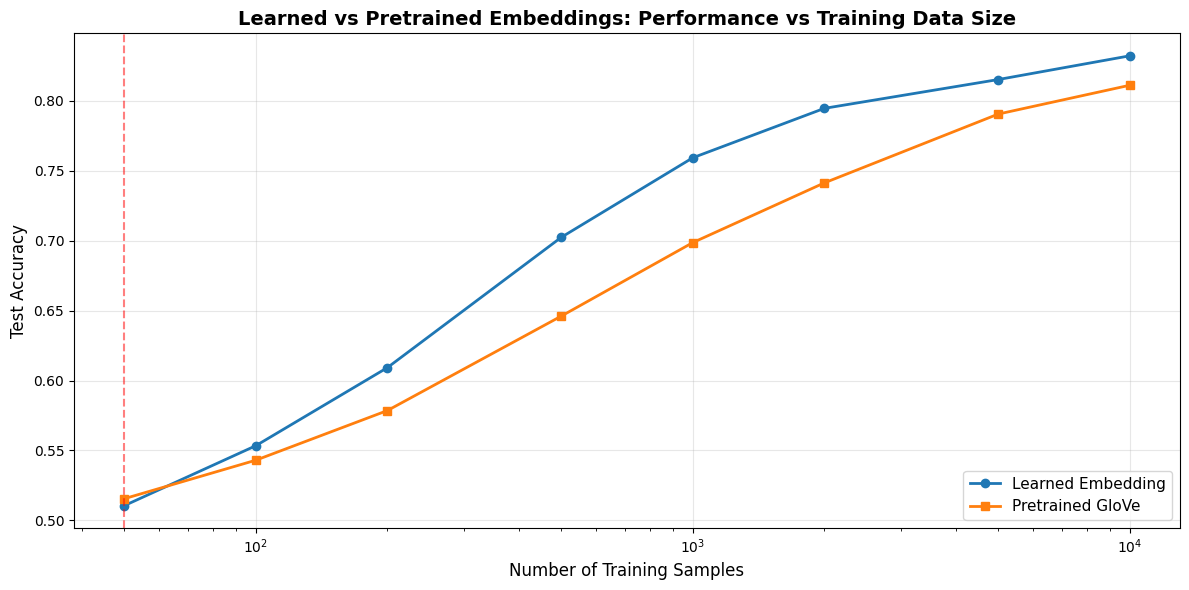


QUESTION 2: AT WHAT POINT DOES LEARNED EMBEDDING GIVE BETTER PERFORMANCE?

Results Table:
--------------------------------------------------------------------------------
Training Samples     Learned Emb     Pretrained Emb  Winner         
--------------------------------------------------------------------------------
50                   0.5106          0.5155          Pretrained     
100                  0.5534          0.5430          Learned        
200                  0.6092          0.5785          Learned        
500                  0.7024          0.6460          Learned        
1000                 0.7592          0.6986          Learned        
2000                 0.7946          0.7413          Learned        
5000                 0.8152          0.7905          Learned        
10000                0.8321          0.8111          Learned        
--------------------------------------------------------------------------------


In [ ]:
def main():
    # Prepare data
    train_ds, val_ds, test_ds = prepare_data()

    # ========================================================================
    # QUESTION 1: WHICH APPROACH WORKS BETTER?
    # ========================================================================
    print("\n" + "=" * 80)
    print("QUESTION 1: Which approach works better?")
    print("  a) Embedding layer (learned from scratch)")
    print("  b) Pretrained word embedding (GloVe)")
    print("=" * 80)

    (int_train_ds, int_val_ds, int_test_ds,
     text_vectorization, max_tokens, max_length) = prepare_limited_dataset(
        train_ds, val_ds, test_ds,
        max_length=150,
        max_tokens=10000,
        num_train_samples=100,
        num_val_samples=10000
    )

    # Build and train model with learned embedding
    print("\nTesting approach (a): Learned Embedding Layer")
    model_embedding = build_model_with_embedding(max_tokens, max_length, embedding_dim=100)
    history_emb, acc_emb = train_and_evaluate(
        model_embedding, int_train_ds, int_val_ds, int_test_ds,
        "learned_embedding_100samples", epochs=10
    )

    # Load GloVe and build model with pretrained embeddings
    print("\nTesting approach (b): Pretrained GloVe Embeddings")
    embeddings_index = load_glove_embeddings(embedding_dim=100)
    embedding_matrix = prepare_glove_embedding_matrix(
        text_vectorization, embeddings_index, max_tokens, embedding_dim=100
    )

    model_pretrained = build_model_with_pretrained_embedding(
        embedding_matrix, max_tokens, embedding_dim=100
    )
    history_pre, acc_pre = train_and_evaluate(
        model_pretrained, int_train_ds, int_val_ds, int_test_ds,
        "pretrained_embedding_100samples", epochs=10
    )

    # Print comparison for Question 1
    print("\n" + "=" * 80)
    print("QUESTION 1: WHICH APPROACH WORKS BETTER?")
    print("=" * 80)
    print("\nConfiguration:")
    print("  - Reviews cutoff: 150 words")
    print("  - Training samples: 100")
    print("  - Validation samples: 10,000")
    print("  - Top words considered: 10,000")
    print("\nResults:")
    print(f"  a) Learned Embedding Test Accuracy:    {acc_emb:.4f}")
    print(f"  b) Pretrained GloVe Test Accuracy:     {acc_pre:.4f}")


    # ========================================================================
    # QUESTION 2: AT WHAT POINT DOES LEARNED EMBEDDING GIVE BETTER PERFORMANCE?
    # ========================================================================
    print("\n\n" + "=" * 80)
    print("QUESTION 2: Now try changing the number of training samples to")
    print("            determine at what point the embedding layer gives")
    print("            better performance.")
    print("=" * 80)

    # Question 2: Vary training sample sizes
    results = compare_training_sample_sizes(
        train_ds, val_ds, test_ds, text_vectorization,
        embeddings_index, max_tokens, max_length
    )

    # Plot results
    plot_results(results)

    # Summary
    print("\n" + "=" * 80)
    print("QUESTION 2: AT WHAT POINT DOES LEARNED EMBEDDING GIVE BETTER PERFORMANCE?")
    print("=" * 80)

    print("\nResults Table:")
    print("-" * 80)
    print(f"{'Training Samples':<20} {'Learned Emb':<15} {'Pretrained Emb':<15} {'Winner':<15}")
    print("-" * 80)
    for i, size in enumerate(results['sample_sizes']):
        learned = results['embedding_acc'][i]
        pretrained = results['pretrained_acc'][i]
        winner = "Learned" if learned > pretrained else "Pretrained"
        print(f"{size:<20} {learned:<15.4f} {pretrained:<15.4f} {winner:<15}")
    print("-" * 80)

if __name__ == "__main__":
    main()